In [1]:
import pandas as pd
from sklearn.impute import KNNImputer
import numpy as np
from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt

Missing values per column:
Region             0
Localisation    2070
Type            1319
Nature            31
Area             335
#Bathrooms       315
#Bedrooms        221
Price             15
dtype: int64


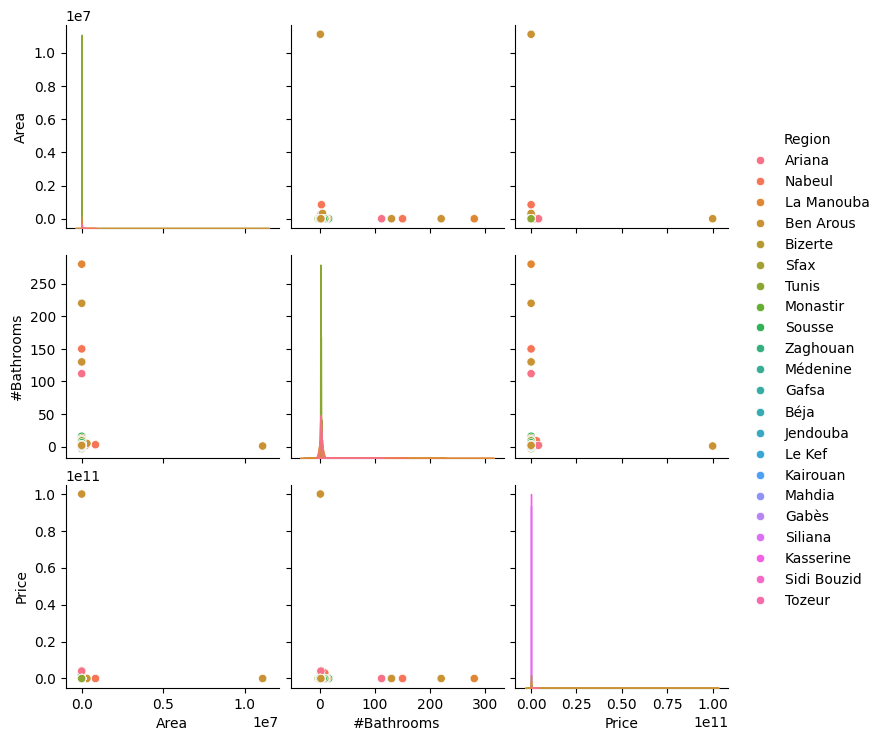

In [ ]:
df = pd.read_csv('data/final_scrapped_immobiliers.csv')

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Choose one categorical column for hue (e.g., 'Region' or 'Type')
sns.pairplot(df, hue='Region')
plt.show()

# Generate a profiling report before cleaning
profile = ProfileReport(df, title="Profiling Report", explorative=True)
profile.to_file("data/immobiliers_report_before_cleaning.html")

Handling missing values in 'Type de bien'

In [3]:
# Convert '#Bedrooms' to numeric
df['#Bedrooms'] = pd.to_numeric(df['#Bedrooms'], errors='coerce')

# Fill missing values in 'Type'
df.loc[(df['Type'].isnull()) & 
       (df['#Bedrooms'].between(1, 4)) & 
       (df['#Bathrooms'].between(1, 2)), 'Type'] = 'Appartement'
df.loc[(df['Type'].isnull()) & 
    (df['#Bedrooms'] > 4) & 
    (df['#Bathrooms'] >= 2), 'Type'] = 'Villa'
df['Type'] = df['Type'].str.capitalize()

# Drop the rest and verify the change
df = df.dropna(subset=['Type'])
print(df['Type'].value_counts())
print("Missing values in 'Type' after:", df['Type'].isnull().sum())

Type
Appartement    2020
Villa          1240
Maison          487
Name: count, dtype: int64
Missing values in 'Type' after: 0


In [4]:
df = df.copy()  # Pour éviter les SettingWithCopyWarning

# Handle Missing Values for 'Localisation' using KNN
df['Localisation_num'] = df['Localisation'].astype('category').cat.codes
localisation_imputer = KNNImputer(n_neighbors=5)
df['Localisation_num'] = localisation_imputer.fit_transform(df[['Localisation_num']])

localisation_mapping = dict(enumerate(df['Localisation'].astype('category').cat.categories))
df['Localisation'] = df['Localisation_num'].round().astype(int).map(localisation_mapping)
df = df.drop(columns=['Localisation_num'])

# Handle Missing Values for 'Area' based on 'Type'
df['Area'] = df.groupby('Type')['Area'].transform(lambda x: x.fillna(x.median()))

# Handle Missing Values for '#Bedrooms'
df['#Bedrooms'] = pd.to_numeric(df['#Bedrooms'], errors='coerce')
knn_imputer = KNNImputer(n_neighbors=5)
df[['#Bedrooms']] = knn_imputer.fit_transform(df[['#Bedrooms']])
df['#Bedrooms'] = df['#Bedrooms'].round()
df['#Bedrooms'] = df['#Bedrooms'].replace(0, np.nan)
df['#Bedrooms'] = df.groupby('Type')['#Bedrooms'].transform(lambda x: x.fillna(x.median()))

# Handle Missing Values for '#Bathrooms' based on 'Type' and 'Localisation'
df['#Bathrooms'] = df.groupby(['Type', 'Localisation'])['#Bathrooms'].transform(
    lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x.fillna(1)
)
df['#Bathrooms'] = df['#Bathrooms'].round()
df['#Bathrooms'] = df['#Bathrooms'].replace(0, np.nan)
df['#Bathrooms'] = df.groupby('Type')['#Bathrooms'].transform(lambda x: x.fillna(x.median()))

df = df.dropna(subset=['Type', 'Localisation'])

# Résultat
print("Missing values after cleaning:")
print(df[['Area', '#Bedrooms', '#Bathrooms', 'Type', 'Localisation']].isnull().sum())

Missing values after cleaning:
Area            0
#Bedrooms       0
#Bathrooms      0
Type            0
Localisation    0
dtype: int64


Handling outliers in 'Price'

In [ ]:
# Remove ouliers based on visualizations
price_quantile = df['Price'].quantile(0.95)
print("Price upper Quantile:")
print(price_quantile)
df['Price'] = df['Price'].clip(upper=price_quantile)

# Drop rows with missing 'Price' and duplicates
df = df.dropna(subset=['Price']).copy()
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

# Check for remaining missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
Region             0
Localisation    1941
Type            1250
Nature            28
Area             319
#Bathrooms       302
#Bedrooms        210
Price              0
dtype: int64


In [10]:
df = pd.read_csv('data/final_data.csv')

# Ensure columns are numeric
df['Area'] = pd.to_numeric(df['Area'], errors='coerce')
df['#Bedrooms'] = pd.to_numeric(df['#Bedrooms'], errors='coerce')
df['#Bathrooms'] = pd.to_numeric(df['#Bathrooms'], errors='coerce')

# Quantile values for Area
superficie_quantiles = df['Area'].quantile([0.022, 0.53, 0.98])
print("Area Quantiles:")
print(superficie_quantiles)

# Quantile values for Bedrooms
nb_chambres_quantiles = df['#Bedrooms'].quantile([0.0013, 0.5, 0.97])
print("#Bedrooms Quantiles:")
print(nb_chambres_quantiles)

# Quantile values for Bathrooms
nb_salles_de_bain_quantiles = df['#Bathrooms'].quantile([0.0013, 0.5, 0.95])
print("#Bathrooms Quantiles:")
print(nb_salles_de_bain_quantiles)

Area Quantiles:
0.022      35.1540
0.530     159.9275
0.980    1100.0000
Name: Area, dtype: float64
#Bedrooms Quantiles:
0.0013   -1.0
0.5000    3.0
0.9700    8.0
Name: #Bedrooms, dtype: float64
#Bathrooms Quantiles:
0.0013    0.0
0.5000    1.0
0.9500    4.0
Name: #Bathrooms, dtype: float64


In [11]:
df = df[
    (df['Area'] >= superficie_quantiles[0.022]) & 
    (df['Area'] <= superficie_quantiles[0.98]) & 
    (df['#Bedrooms'] >= nb_chambres_quantiles[0.0013]) & 
    (df['#Bedrooms'] <= nb_chambres_quantiles[0.97]) & 
    (df['#Bathrooms'] >= nb_salles_de_bain_quantiles[0.0013]) & 
    (df['#Bathrooms'] <= nb_salles_de_bain_quantiles[0.95])
]

In [19]:
# Drop rows where 'Nature' is 'À louer' then drop the column (all rows are 'À Vendre')
df = df[df['Nature'] != 'À Louer'].copy()
df = df.drop(columns=['Nature'])

df = df.dropna().copy()
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

# Check for remaining missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
Region        0
Type          0
Area          0
#Bathrooms    0
#Bedrooms     0
Price         0
dtype: int64


In [13]:
print("Unique values in 'Region':")
print(df['Region'].unique())

print("\nUnique values in 'Localisation':")
print(df['Localisation'].unique())

Unique values in 'Region':
['Ariana' 'Nabeul' 'La Manouba' 'Ben Arous' 'Bizerte' 'Tunis' 'Sfax'
 'Monastir' 'Sousse' 'Médenine' 'Gafsa' 'Jendouba' 'Le Kef' 'Kairouan'
 'Mahdia' 'Gabès' 'Zaghouan' 'Siliana' 'Béja' 'Kasserine' 'Sidi Bouzid'
 'Tozeur']

Unique values in 'Localisation':
['Ariana' 'Nabeul' 'La_Manouba' 'Ben_Arous' 'Bizerte' 'Tunis' 'Sfax'
 'Monastir' 'Sousse' 'Mdenine' 'Gafsa' 'Jendouba' 'Le_Kef' 'Kairouan'
 'Mahdia' 'Gabs' 'Zaghouan' 'Siliana' 'Bja' 'Kasserine' 'Sidi_Bouzid'
 'Tozeur']


In [ ]:
df = df.drop(columns=['Localisation'])

df.to_csv('data/final_data.csv', index=False)
profile = ProfileReport(df, title="Profiling Report", explorative=True)
profile.to_file("data/immobiliers_report_after_cleaning.html")

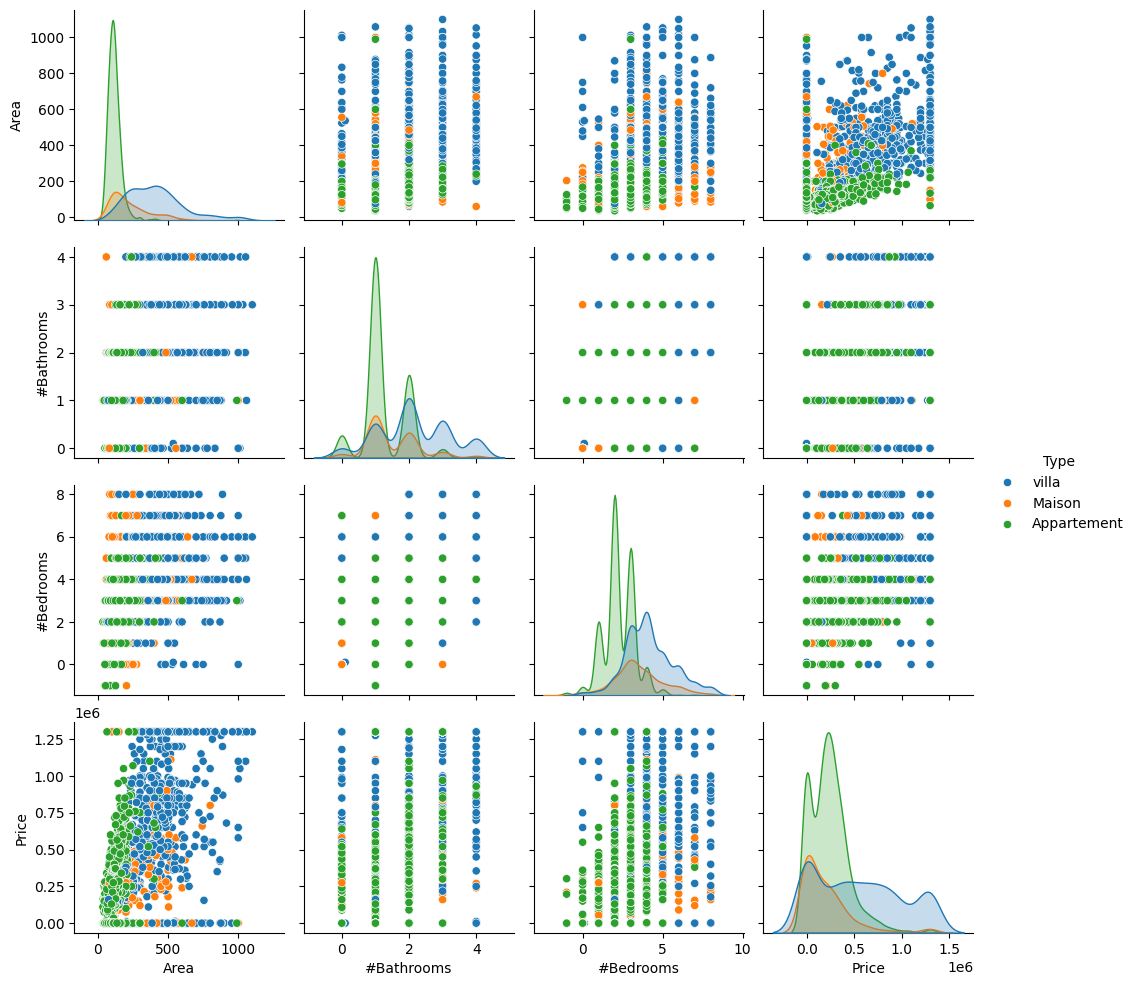

In [ ]:
sns.pairplot(df, hue= "Type")
plt.show()

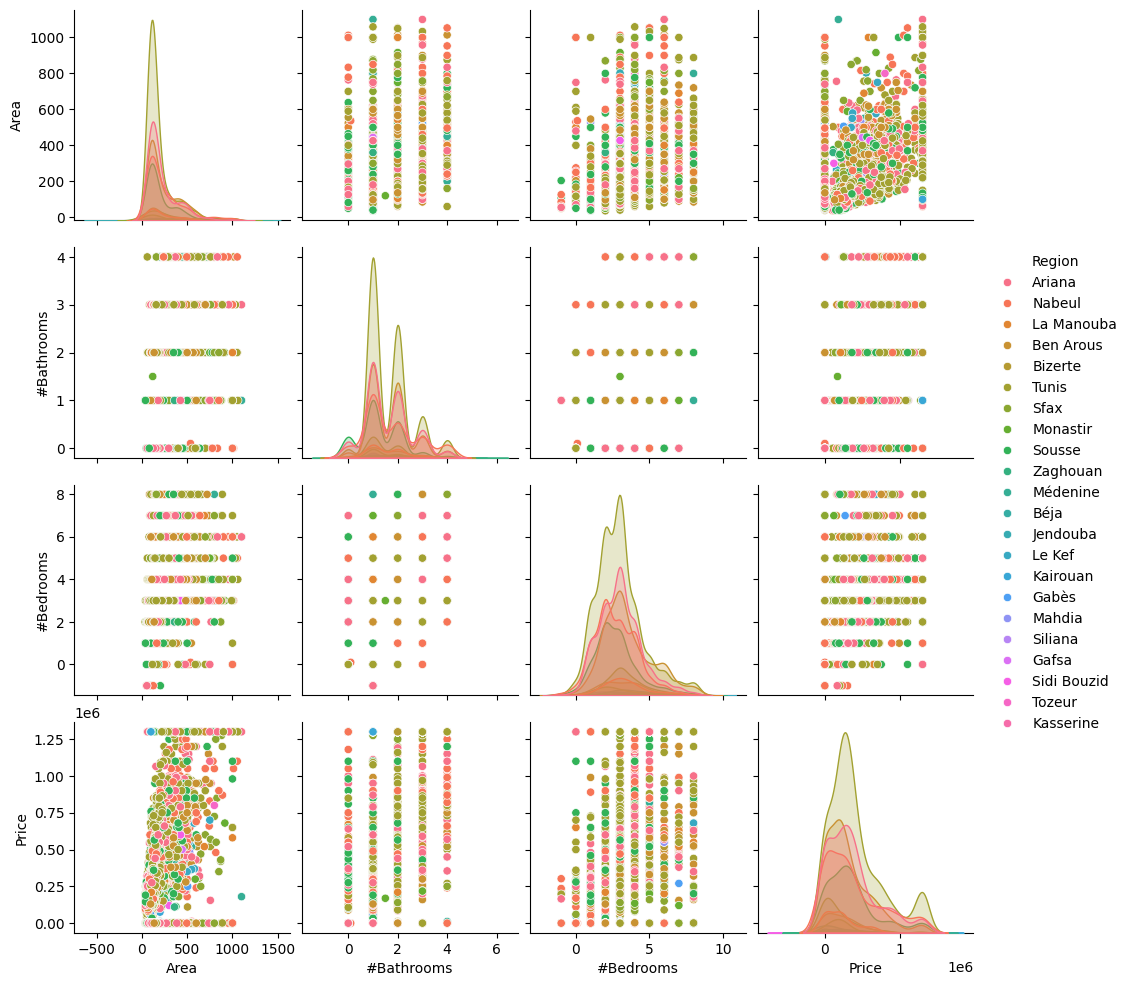

In [15]:
sns.pairplot(df, hue= "Region")
plt.show()